In [1]:
#import basic libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspe
import seaborn as sns
import polars as pl

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.optimize import minimize

# I. Data Exploratory Analysis (EDA) & Data Prepossessing 

## 1. Data Loading

In [2]:
dic = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

##  2. Data Preview

### 2.1. Preview Data_dictionary
The HBN dataset has total 11 instruments. Each one are presented by some fields calculated below. The total number of fields collected is 80 (excluding id).

In [3]:
# Preview data_dictionary
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
dic.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [4]:
# Summarise data_dictionary
grouped = dic.groupby('Instrument', sort=False)['Field'].apply(lambda x: ', '.join(x)).reset_index()
grouped['NumFields'] = dic.groupby('Instrument', sort=False).size().values
grouped = grouped.style.set_properties(**{'text-align': 'left'}, subset=['Instrument', 'Field', 'NumFields']) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])

grouped

,Instrument,Field,NumFields
0,Identifier,id,1
1,Demographics,"Basic_Demos-Enroll_Season, Basic_Demos-Age, Basic_Demos-Sex",3
2,Children's Global Assessment Scale,"CGAS-Season, CGAS-CGAS_Score",2
3,Physical Measures,"Physical-Season, Physical-BMI, Physical-Height, Physical-Weight, Physical-Waist_Circumference, Physical-Diastolic_BP, Physical-HeartRate, Physical-Systolic_BP",8
4,FitnessGram Vitals and Treadmill,"Fitness_Endurance-Season, Fitness_Endurance-Max_Stage, Fitness_Endurance-Time_Mins, Fitness_Endurance-Time_Sec",4
5,FitnessGram Child,"FGC-Season, FGC-FGC_CU, FGC-FGC_CU_Zone, FGC-FGC_GSND, FGC-FGC_GSND_Zone, FGC-FGC_GSD, FGC-FGC_GSD_Zone, FGC-FGC_PU, FGC-FGC_PU_Zone, FGC-FGC_SRL, FGC-FGC_SRL_Zone, FGC-FGC_SRR, FGC-FGC_SRR_Zone, FGC-FGC_TL, FGC-FGC_TL_Zone",15
6,Bio-electric Impedance Analysis,"BIA-Season, BIA-BIA_Activity_Level_num, BIA-BIA_BMC, BIA-BIA_BMI, BIA-BIA_BMR, BIA-BIA_DEE, BIA-BIA_ECW, BIA-BIA_FFM, BIA-BIA_FFMI, BIA-BIA_FMI, BIA-BIA_Fat, BIA-BIA_Frame_num, BIA-BIA_ICW, BIA-BIA_LDM, BIA-BIA_LST, BIA-BIA_SMM, BIA-BIA_TBW",17
7,Physical Activity Questionnaire (Adolescents),"PAQ_A-Season, PAQ_A-PAQ_A_Total",2
8,Physical Activity Questionnaire (Children),"PAQ_C-Season, PAQ_C-PAQ_C_Total",2
9,Parent-Child Internet Addiction Test,"PCIAT-Season, PCIAT-PCIAT_01, PCIAT-PCIAT_02, PCIAT-PCIAT_03, PCIAT-PCIAT_04, PCIAT-PCIAT_05, PCIAT-PCIAT_06, PCIAT-PCIAT_07, PCIAT-PCIAT_08, PCIAT-PCIAT_09, PCIAT-PCIAT_10, PCIAT-PCIAT_11, PCIAT-PCIAT_12, PCIAT-PCIAT_13, PCIAT-PCIAT_14, PCIAT-PCIAT_15, PCIAT-PCIAT_16, PCIAT-PCIAT_17, PCIAT-PCIAT_18, PCIAT-PCIAT_19, PCIAT-PCIAT_20, PCIAT-PCIAT_Total",22


### 2.2. Preview Train & Test data

In [5]:
# training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

2736 non-null in sii => 
sii missing is about 30% (accepted to remove), so only use part with sii valid to train the supervised model for accurately.

In [6]:
usable_train_df = train_df.dropna(subset='sii')
usable_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    float64
 

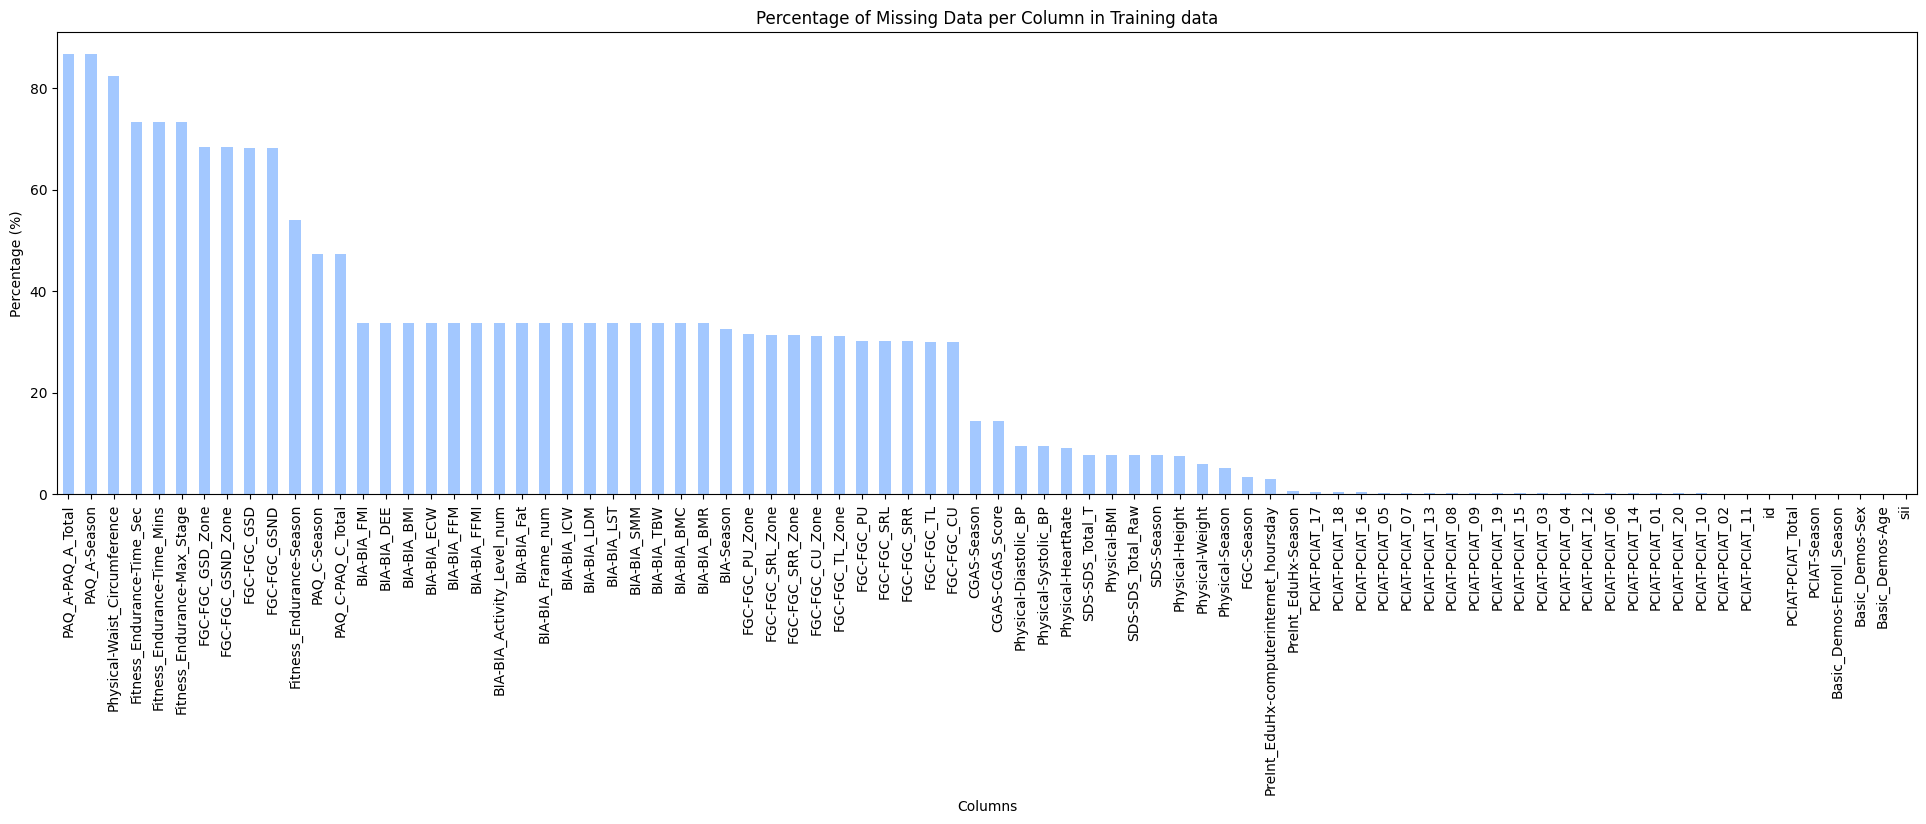

In [7]:
missing_percentage = (usable_train_df.isnull().sum() / len(usable_train_df)) * 100 # calculate % missing data

missing_percentage.sort_values(ascending=False).plot(kind='bar', color='#A3C8FF', figsize=(24, 6))
plt.title('Percentage of Missing Data per Column in Training data')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns');

In [8]:
#Testing data
test_df.info()
# 58 fields measured (excluding id) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


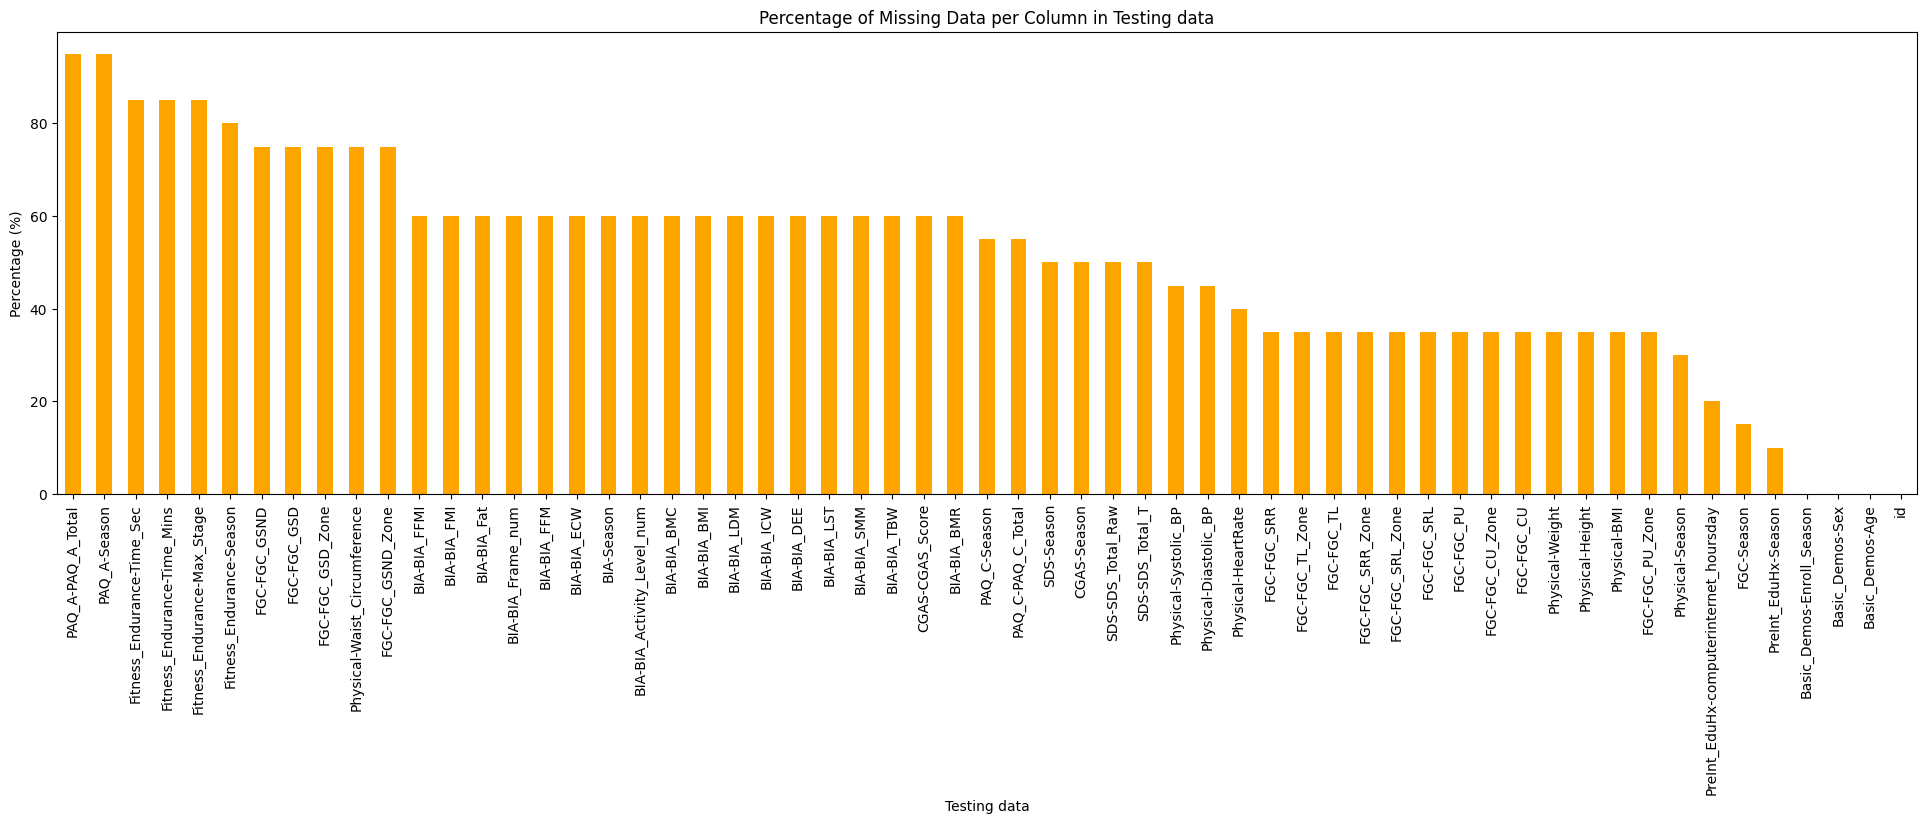

In [9]:
missing_percentage_test = (test_df.isnull().sum() / len(test_df)) * 100 # calculate % missing data

missing_percentage_test.sort_values(ascending=False).plot(kind='bar', color='orange', figsize=(24, 6))
plt.title('Percentage of Missing Data per Column in Testing data')
plt.ylabel('Percentage (%)')
plt.xlabel('Testing data');

In [10]:
# find the difference between 2 files
columns_train = set(usable_train_df.columns)
columns_test = set(test_df.columns)
difference = sorted(list(columns_train - columns_test)) #Find the difference columns in 2 data files
print(difference) # 23

['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'PCIAT-Season', 'sii']


In [11]:
# Actigraphy (time series) data
#example
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


### 2.3. Features Classification

In [12]:
# Identify the type of fields (features to train)
def print_column_info(column_type, column_name):
    cols = dic[dic['Type'] == column_type]['Field']
    print(f"{column_name}: {len(cols)}")
    print(cols.values)
    print("\n")

print_column_info('float', 'Continuous')
print_column_info('int', 'Discrete')
print_column_info('str', 'Categorical')
print_column_info('categorical int', 'Categorical Int')


Continuous: 24
['Basic_Demos-Age' 'Physical-BMI' 'Physical-Height' 'Physical-Weight'
 'FGC-FGC_GSND' 'FGC-FGC_GSD' 'FGC-FGC_SRL' 'FGC-FGC_SRR' 'BIA-BIA_BMC'
 'BIA-BIA_BMI' 'BIA-BIA_BMR' 'BIA-BIA_DEE' 'BIA-BIA_ECW' 'BIA-BIA_FFM'
 'BIA-BIA_FFMI' 'BIA-BIA_FMI' 'BIA-BIA_Fat' 'BIA-BIA_ICW' 'BIA-BIA_LDM'
 'BIA-BIA_LST' 'BIA-BIA_SMM' 'BIA-BIA_TBW' 'PAQ_A-PAQ_A_Total'
 'PAQ_C-PAQ_C_Total']


Discrete: 14
['CGAS-CGAS_Score' 'Physical-Waist_Circumference' 'Physical-Diastolic_BP'
 'Physical-HeartRate' 'Physical-Systolic_BP' 'Fitness_Endurance-Max_Stage'
 'Fitness_Endurance-Time_Mins' 'Fitness_Endurance-Time_Sec' 'FGC-FGC_CU'
 'FGC-FGC_PU' 'FGC-FGC_TL' 'PCIAT-PCIAT_Total' 'SDS-SDS_Total_Raw'
 'SDS-SDS_Total_T']


Categorical: 12
['id' 'Basic_Demos-Enroll_Season' 'CGAS-Season' 'Physical-Season'
 'Fitness_Endurance-Season' 'FGC-Season' 'BIA-Season' 'PAQ_A-Season'
 'PAQ_C-Season' 'PCIAT-Season' 'SDS-Season' 'PreInt_EduHx-Season']


Categorical Int: 31
['Basic_Demos-Sex' 'FGC-FGC_CU_Zone' 'FGC-FGC_GSN

In [13]:
usable_train_df = train_df.dropna(subset='sii')
usable_train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    float64
 

### 2.4. Distribution of features

In [14]:
# Distribution of numerical features
usable_train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,2736.000000,2736.000000,2342.000000,2527.000000,2530.000000,2572.000000,483.000000,2478.000000,2486.000000,2478.000000,731.000000,728.000000,728.000000,1919.000000,1884.000000,872.000000,864.000000,871.000000,864.000000,1909.000000,1875.000000,1911.000000,1877.000000,1913.000000,1879.000000,1919.000000,1885.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,363.000000,1440.000000,2733.000000,2734.000000,2731.000000,2731.000000,2729.000000,2732.000000,2729.000000,2730.000000,2730.000000,2733.000000,2734.000000,2731.000000,2729.000000,2732.000000,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2527.000000,2525.000000,2654.000000,2736.000000
mean,10.238670,0.364401,65.159266,19.125667,55.897051,87.839592,26.625259,69.755044,81.823411,117.127926,5.001368,7.394231,27.656593,11.912976,0.524947,22.077970,1.820602,23.083639,1.887731,5.782609,0.347200,8.767975,0.636654,8.877888,0.634380,9.119567,0.772944,2.671263,6.954484,19.232347,1236.604226,2069.411478,20.781963,73.977613,14.992021,4.240327,15.827994,1.733591,33.134537,20.061121,67.023130,34.372294,53.916500,2.185758,2.590608,2.370655,2.177762,2.399854,0.839253,2.297545,1.063690,0.586295,1.246520,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,40.977839,57.647525,1.015072,0.580409
std,3.427982,0.481350,11.811050,4.909305,7.394938,43.353079,5.230213,13.790203,13.769816,17.221707,2.016711,3.180463,17.756420,11.979877,0.499510,10.484763,0.613854,10.517376,0.616601,7.441061,0.476207,3.289944,0.481091,3.320215,0.481732,2.954478,0.419040,1.030997,97.022087,4.921900,1960.147933,2966.453800,76.697505,208.781862,6.012465,6.538342,208.771419,0.671201,58.852697,73.538391,113.554916,87.917006,135.377293,0.815263,0.786610,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.231384,13.042815,1.080861,0.771122
min,5.000000,0.000000,25.000000,0.000000,36.000000,0.000000,19.000000,11.000000,27.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,17.845000,4.635810,23.620100,11.382500,20.589200,0.660000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.773447,50.050000,57.200

In [15]:
usable_train_df.select_dtypes(include=["object"]).describe()

,id,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
count,2736,2736,2342,2595,1260,2647,1844,363,1440,2736,2527,2719
unique,2736,4,4,4,4,4,4,4,4,4,4,4
top,00008ff9,Spring,Spring,Spring,Spring,Spring,Summer,Winter,Spring,Spring,Spring,Spring
freq,1,734,665,709,377,771,585,98,405,762,692,728


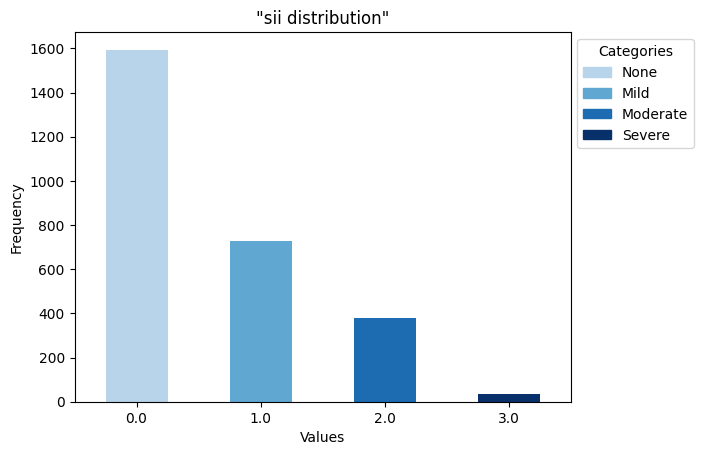

In [16]:
# sii distribution → sii is imbalanced, half of it is 0
sii_counts = usable_train_df['sii'].value_counts()
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sii_counts)))

#plt.figure(figsize=(12, 6))
sii_counts.plot(kind='bar', color=colors)
plt.title('"sii distribution"')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
legend_labels = ['None', 'Mild', 'Moderate', 'Severe']
colors_for_legend = colors
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_for_legend],
           labels=legend_labels, title="Categories", loc='upper left', bbox_to_anchor=(1, 1));


### 3.1. Encode Season columns

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

columns_to_encode = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

for col in columns_to_encode:
    usable_train_df.loc[:, col] = encoder.fit_transform(usable_train_df[col])

### 3.2. Encode Actigraphy data


## EDA

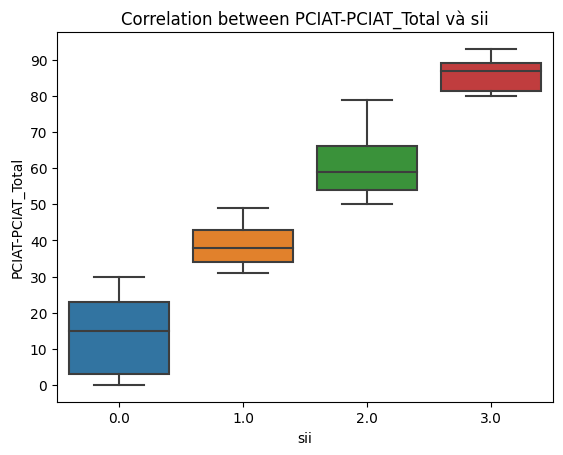

In [18]:
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=usable_train_df)
plt.title('Correlation between PCIAT-PCIAT_Total và sii')
plt.xlabel('sii')
plt.ylabel('PCIAT-PCIAT_Total')
y_ticks = np.arange(usable_train_df['PCIAT-PCIAT_Total'].min(), usable_train_df['PCIAT-PCIAT_Total'].max(), 10)
plt.yticks(y_ticks);

The target ```sii``` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score.
* 0-30 Normal (0)
* 31-49 Mild (1)
* 50-79 Moderate (2)
* 80-100 Severe (3)

Proof: https://digitalwellnesslab.org/wp-content/uploads/Scoring-Overview.pdf

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
Physical-Waist_Circumference              0.327013
Physical-Systolic_BP                      0.147081
FGC-FGC_CU                                0.287494
FGC-FGC_PU                                0.196006
FGC-FGC_TL                                0.136696
SDS-SDS_Total_Raw                         0.234432
SDS-SDS_Total_T                           0.237718
PreInt_EduHx-computerinternet_hoursday    0.374124
FGC-FGC_SRL_Zone                         -0.148850
FGC-FGC_SRR_Zone                         -0.109682
BIA-BIA_Frame_num                         0.193631
Fitness_Endurance-Season       

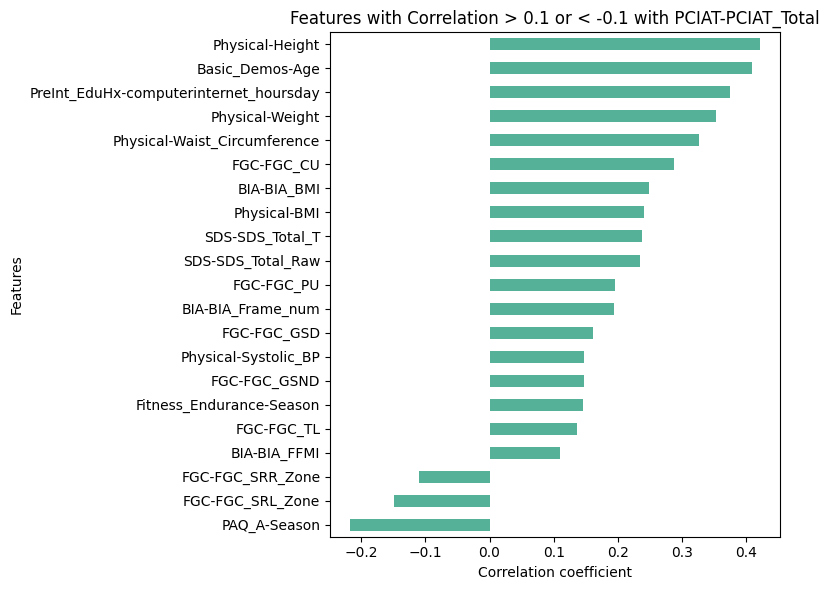

In [19]:
# Check correlation between numerical features and PCIAT Total Scores

corr_matrix = usable_train_df[[
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
 'FGC-FGC_GSND' ,'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'BIA-BIA_BMC',
 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE' ,'BIA-BIA_ECW', 'BIA-BIA_FFM',
 'BIA-BIA_FFMI' ,'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW' ,'BIA-BIA_LDM',
 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
 'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score' ,'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
 'Physical-HeartRate', 'Physical-Systolic_BP' ,'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec' ,'FGC-FGC_CU',
 'FGC-FGC_PU', 'FGC-FGC_TL' ,'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
    
    'Basic_Demos-Sex', 'FGC-FGC_CU_Zone' ,'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone' ,'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num', 
    
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]].corr()

# Lấy các cột có tương quan > 0.1 hoặc < -0.1 với PCIAT-PCIAT_Total
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='#55B197')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# II. Feature Engineering

### 2.1 Feature selection

In [20]:
# choose features
featuresCols = ['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 
         'FGC-FGC_GSND', 'FGC-FGC_GSD', 'BIA-BIA_BMI', 'BIA-BIA_FFMI', 'Physical-Waist_Circumference', 
         'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 
         'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 
         'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'BIA-BIA_Frame_num', 'Fitness_Endurance-Season', 'PAQ_A-Season']
#filter features has >50% missing data
columns_with_missing = missing_percentage[missing_percentage > 50].index
missCols = usable_train_df[columns_with_missing]
# print(missCols)

selectedFeatures = list(set(featuresCols) - set(missCols))
Selected_df = usable_train_df[selectedFeatures]
Selected_df.info() #final training df

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SDS-SDS_Total_Raw                       2527 non-null   float64
 1   BIA-BIA_BMI                             1813 non-null   float64
 2   FGC-FGC_TL                              1919 non-null   float64
 3   BIA-BIA_Frame_num                       1813 non-null   float64
 4   Physical-BMI                            2527 non-null   float64
 5   SDS-SDS_Total_T                         2525 non-null   float64
 6   BIA-BIA_FFMI                            1813 non-null   float64
 7   Physical-Height                         2530 non-null   float64
 8   FGC-FGC_SRL_Zone                        1877 non-null   float64
 9   PreInt_EduHx-computerinternet_hoursday  2654 non-null   float64
 10  Basic_Demos-Age                         2736 non-null   int64  
 

### 2.2. Clean Data

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=20, random_state=0)

Selected_df = pd.DataFrame(imputer.fit_transform(Selected_df), columns=Selected_df.columns)
#Selected_df

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [22]:
Selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SDS-SDS_Total_Raw                       2736 non-null   float64
 1   BIA-BIA_BMI                             2736 non-null   float64
 2   FGC-FGC_TL                              2736 non-null   float64
 3   BIA-BIA_Frame_num                       2736 non-null   float64
 4   Physical-BMI                            2736 non-null   float64
 5   SDS-SDS_Total_T                         2736 non-null   float64
 6   BIA-BIA_FFMI                            2736 non-null   float64
 7   Physical-Height                         2736 non-null   float64
 8   FGC-FGC_SRL_Zone                        2736 non-null   float64
 9   PreInt_EduHx-computerinternet_hoursday  2736 non-null   float64
 10  Basic_Demos-Age                         2736 non-null   floa

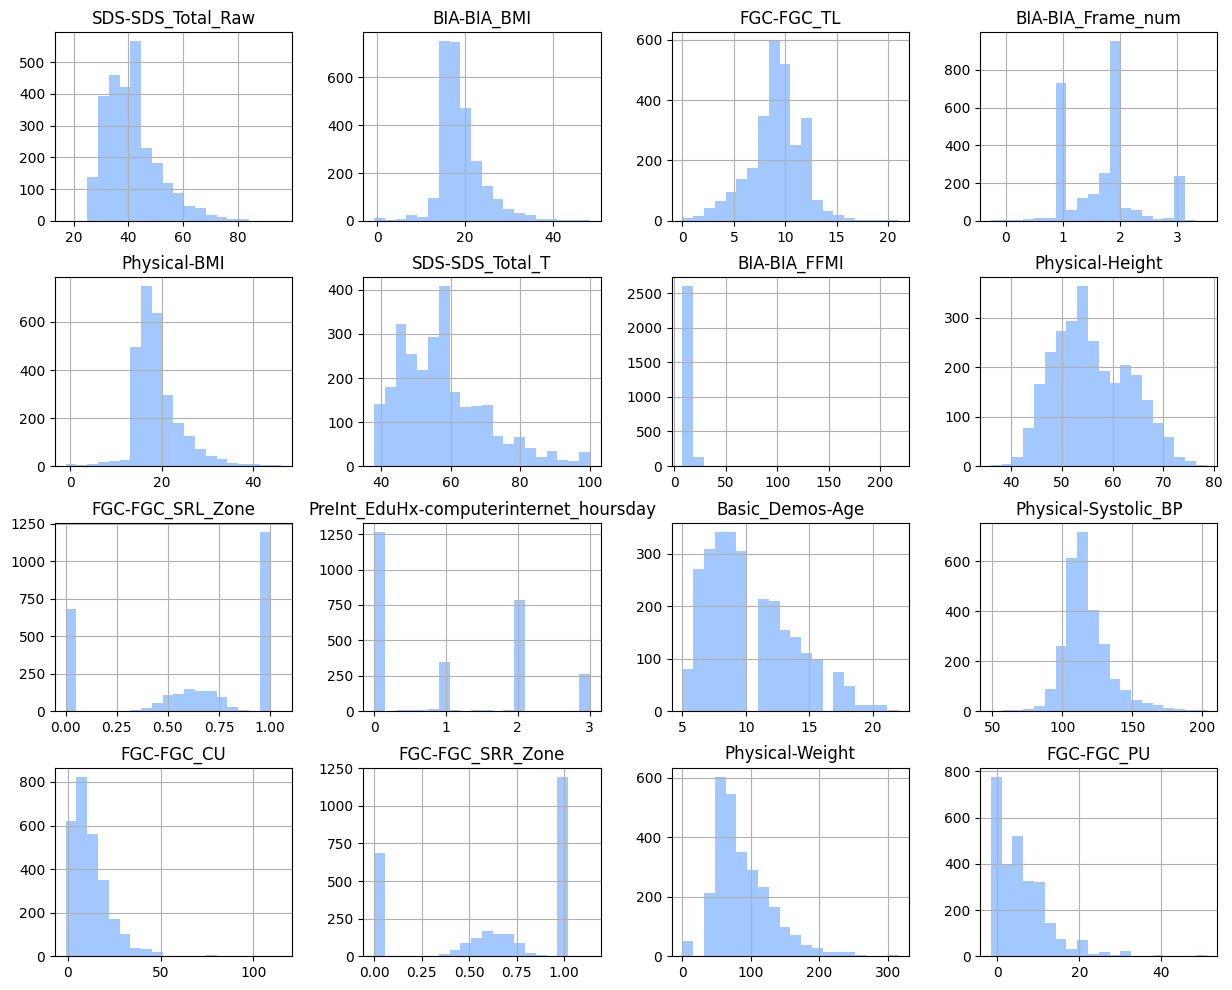

In [23]:
Selected_df.hist(figsize=(15, 12), bins=20, color='#A3C8FF');

# III. Model training

In [24]:
# Calculate Kappa
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Categorize based on 4 threshold (0-3)
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [25]:
# define input
X = Selected_df;
y = usable_train_df['sii']
test = test_df[selectedFeatures]

In [26]:
test.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SDS-SDS_Total_Raw                       10 non-null     float64
 1   BIA-BIA_BMI                             8 non-null      float64
 2   FGC-FGC_TL                              13 non-null     float64
 3   BIA-BIA_Frame_num                       8 non-null      float64
 4   Physical-BMI                            13 non-null     float64
 5   SDS-SDS_Total_T                         10 non-null     float64
 6   BIA-BIA_FFMI                            8 non-null      float64
 7   Physical-Height                         13 non-null     float64
 8   FGC-FGC_SRL_Zone                        13 non-null     float64
 9   PreInt_EduHx-computerinternet_hoursday  16 non-null     float64
 10  Basic_Demos-Age                         20 non-null     int64  


### Model

In [27]:
Params_LGB = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01,
    'device': 'cpu'  # Thay 'gpu' bằng 'cpu'
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 0,
    'tree_method': 'hist',  # Thay 'gpu_hist' bằng 'hist' để dùng CPU
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 0,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'CPU'  # Thay 'GPU' bằng 'CPU'
}


In [28]:
lgb_model = lgb.LGBMClassifier(**Params_LGB)
xgb_model = xgb.XGBClassifier(**XGB_Params)
catboost_model = cb.CatBoostClassifier(**CatBoost_Params)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model)
    ]
)

In [29]:
lgb_model = lgb.LGBMClassifier(**Params_LGB)
xgb_model = xgb.XGBClassifier(**XGB_Params)
catboost_model = cb.CatBoostClassifier(**CatBoost_Params)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model)
    ],
    voting='soft'  # "soft" choose with highest prob
)

def ModelTraining(X,y, test_data):
    SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
   
    # store QWK
    train_S = []
    test_S = []
    
    # create array storing prediction to calculate QWK
    oof_non_rounded = np.zeros(len(y), dtype=float)  # used for training set
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), 10))  # used for testing set

    # training loop
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=10)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        
        voting_clf.fit(X_train, y_train)

        # predict on traing & testing set
        y_train_pred = voting_clf.predict(X_train)
        y_val_pred = voting_clf.predict(X_val)
        
        # update prediction
        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        # Calculate QWK for training and validation
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)
        
        # Store QWK scores for each fold
        train_S.append(train_kappa)
        test_S.append(val_kappa)

        # Store the predictions for the test set
        test_preds[:, fold] = voting_clf.predict(test_data)

    # After all folds
    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK --> {np.mean(test_S):.4f}")

    # Optimize threshold
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    
    
    # Tune the OOF predictions using optimized thresholds
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    # Average test predictions across all folds
    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    # Create the submission
    submission = pd.DataFrame({
        'id': test_df['id'],
        'sii': tpTuned
    })

    return submission


In [30]:
submission = ModelTraining(X, y, test)

Training Folds:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  10%|█         | 1/10 [00:04<00:38,  4.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  20%|██        | 2/10 [00:07<00:31,  3.88s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  30%|███       | 3/10 [00:11<00:27,  3.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  40%|████      | 4/10 [00:15<00:23,  3.85s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  50%|█████     | 5/10 [00:19<00:18,  3.78s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  60%|██████    | 6/10 [00:22<00:14,  3.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  70%|███████   | 7/10 [00:26<00:11,  3.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  80%|████████  | 8/10 [00:30<00:07,  3.71s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds:  90%|█████████ | 9/10 [00:34<00:03,  3.71s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

Training Folds: 100%|██████████| 10/10 [00:37<00:00,  3.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will 

In [31]:
submission.to_csv("submission.csv", index=False)